In [1]:
import numpy as np
import torch
from math import ceil, comb

import quairkit as qkit
from quairkit import Circuit, Hamiltonian, to_state
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qite import afm_random_jump, to_liouville, algorithm2, model_ding2024simulating, model_peng2025quantum, model_yu2025lindbladian, model_huang2025robust

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FuncFormatter

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 15

Since afm part involve random generation of jump operators, we fix one seed to reproduce our plot data (so that pre-computed QSP angles can be directly load). One can uncomment this line to obtain a different but similar result.

In [4]:
qkit.set_seed(20250828)
qkit.get_seed()

20250828

## Experiment setting

In [5]:
num_qubits = 4
rho0 = zero_state(num_qubits)

In [6]:
def trial(t: float, list_model: list) -> tuple:
    r"""A trial experiment to run Lindbladian simulation algorithm
    
    Returns:
        The error and overall success probability of the simulation.
    """
    num_step = max(ceil(t ** 3), 1)
    
    list_error, list_cost = [], []
    for Hc, H in list_model:
        error, resource_cost = algorithm2(t, num_step, rho0, Hc, H)
        list_error.append(error)
        list_cost.append(resource_cost)
    
    list_error, list_cost = np.log10(np.array(list_error)), np.log10(np.array(list_cost).astype(float))
    return np.mean(list_error), np.mean(list_cost), np.std(list_error), np.std(list_cost)

prepare four TF Ising models in different papers.

In [7]:
list_setting = [model_ding2024simulating(num_qubits),
                model_peng2025quantum(num_qubits),
                model_yu2025lindbladian(num_qubits),
                model_huang2025robust(num_qubits)]
list_model_tfim = [to_liouville(system_hamiltonian, jump_operators) for system_hamiltonian, jump_operators in list_setting]

prepare AFM Heisenberg model and random jump operators, where the number of jump operators equals to the number of qubits.

In [8]:
num_trials = 5
list_model_afm = [to_liouville(*afm_random_jump(num_qubits)) for _ in range(num_trials)]

## Compute data

TFIM data

In [9]:
max_t = 20
list_t = list(np.arange(max_t, 0, -0.4))

list_error_mean_tfim, list_cost_mean_tfim = [], []
list_error_std_tfim, list_cost_std_tfim = [], []

for t in list_t:
    error_mean_tfim, cost_mean_tfim, error_std_tfim, cost_std_tfim = trial(t, list_model_tfim)
    list_error_mean_tfim.append(error_mean_tfim)
    list_cost_mean_tfim.append(cost_mean_tfim)
    list_error_std_tfim.append(error_std_tfim)
    list_cost_std_tfim.append(cost_std_tfim)

In [10]:
np.save('data/figure3a_data.npy', [list_t, list_error_mean_tfim, list_cost_mean_tfim, list_error_std_tfim, list_cost_std_tfim])

afm data

In [11]:
max_t = 20
list_t = list(np.arange(max_t, 0, -0.4))

list_error_mean_afm, list_cost_mean_afm = [], []
list_error_std_afm, list_cost_std_afm = [], []

for t in list_t:
    error_mean_afm, cost_mean_afm, error_std_afm, cost_std_afm = trial(t, list_model_afm)
    list_error_mean_afm.append(error_mean_afm)
    list_cost_mean_afm.append(cost_mean_afm)
    list_error_std_afm.append(error_std_afm)
    list_cost_std_afm.append(cost_std_afm)

In [12]:
np.save('data/figure3b_data.npy', [list_t, list_error_mean_afm, list_cost_mean_afm, list_error_std_afm, list_cost_std_afm])

## Plot

tfim

In [13]:
list_t, list_error_mean, list_cost_mean, list_error_std, list_cost_std = np.load('data/figure3a_data.npy')

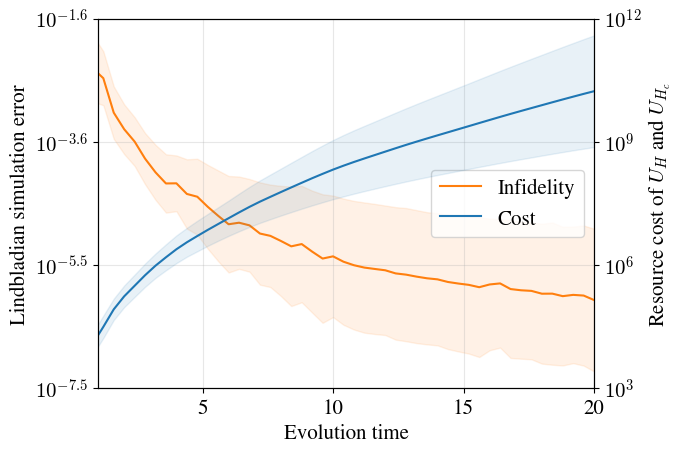

In [14]:
# sort by ascending time
data = sorted(zip(list_t, list_cost_mean, list_cost_std, list_error_mean, list_error_std), key=lambda x: x[0])
t, cost_mean, cost_std, error_mean, error_std = [np.array(v) for v in zip(*data)]

fig, ax1 = plt.subplots()
c1, c2 = 'C0', 'C1'

error_line, = ax1.plot(t, error_mean, color=c2, label='Infidelity', zorder=3)
error_env = ax1.fill_between(t, error_mean - error_std, error_mean + error_std, color=c2, alpha=0.1, zorder=1)
ax1.set_xlabel('Evolution time')
ax1.set_ylabel(r'Lindbladian simulation error')
ax1.set_xticks([5, 10, 15, 20])
ax1.set_xlim(1, 20)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
cost_line, = ax2.plot(t, cost_mean, color=c1, label='Cost')
cost_env = ax2.fill_between(t, cost_mean - cost_std, cost_mean + cost_std, color=c1, alpha=0.1, zorder=1)
ax2.set_ylabel(r'Resource cost of $U_H$ and $U_{H_c}$')
ax2.tick_params(axis='y')

num_ticks = 4
for ax in (ax1, ax2):
    ax.yaxis.set_major_locator(LinearLocator(num_ticks))
    
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: r'$10^{' + f'{x:,.1f}' + r'}$'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: r'$10^{' + f'{x:,.0f}' + r'}$'))

handles = [error_line, cost_line]
ax1.legend(handles, [h.get_label() for h in handles], loc='right')
ax1.grid(True, alpha=0.3)
plt.show()

afm

In [15]:
list_t, list_error_mean, list_cost_mean, list_error_std, list_cost_std = np.load('data/figure3b_data.npy')

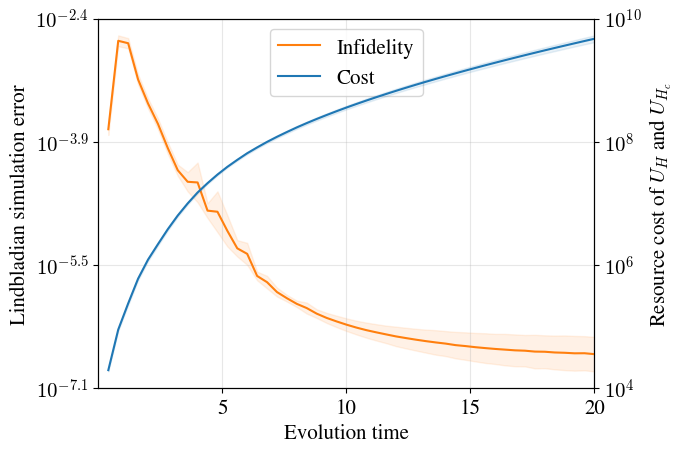

In [16]:
# sort by ascending time
data = sorted(zip(list_t, list_cost_mean, list_cost_std, list_error_mean, list_error_std), key=lambda x: x[0])
t, cost_mean, cost_std, error_mean, error_std = [np.array(v) for v in zip(*data)]

fig, ax1 = plt.subplots()
c1, c2 = 'C0', 'C1'

error_line, = ax1.plot(t, error_mean, color=c2, label='Infidelity', zorder=3)
error_env = ax1.fill_between(t, error_mean - error_std, error_mean + error_std, color=c2, alpha=0.1, zorder=1)
ax1.set_xlabel('Evolution time')
ax1.set_ylabel(r'Lindbladian simulation error')
ax1.set_xticks([5, 10, 15, 20])
ax1.set_xlim(0, 20)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
cost_line, = ax2.plot(t, cost_mean, color=c1, label='Cost')
cost_env = ax2.fill_between(t, cost_mean - cost_std, cost_mean + cost_std, color=c1, alpha=0.1, zorder=1)
ax2.set_ylabel(r'Resource cost of $U_H$ and $U_{H_c}$')
ax2.tick_params(axis='y')

num_ticks = 4
for ax in (ax1, ax2):
    ax.yaxis.set_major_locator(LinearLocator(num_ticks))
    
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: r'$10^{' + f'{x:,.1f}' + r'}$'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: r'$10^{' + f'{x:,.0f}' + r'}$'))

handles = [error_line, cost_line]
ax1.legend(handles, [h.get_label() for h in handles], loc='upper center')
ax1.grid(True, alpha=0.3)
plt.show()

---

In [17]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.9.1+cu128
torch cuda: 12.8
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.7
---------SYSTEM---------
Python version: 3.14.0
OS: Linux
OS version: #88-Ubuntu SMP PREEMPT_DYNAMIC Sat Oct 11 09:28:41 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9554 64-Core Processor
GPU: (0) NVIDIA GeForce RTX 3090
     (0) NVIDIA GeForce RTX 3090
